# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchcontrib.optim import SWA
import torchcontrib
from torch.optim.swa_utils import SWALR
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [3]:
# 시드(seed) 설정
#def seed_everything(seed):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    #np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

#seed_everything(100)

In [4]:
# working directory 지정
ROOT_PATH = './'
DATA_DIR = os.path.join(ROOT_PATH, 'pangyo_ai', 'task01_mask', 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'task01_mask_results')
if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (240, 240)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape, augment=False, augtype='imagenet'):

        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        self.augment = augment
        
        if os.path.isfile(os.path.join(RESULT_DIR, 'total.pkl')):
            self.db = pd.read_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
        else:
            self.db = self.data_loader()
            self.db = self.db.sample(frac=1).reset_index()
            self.db.to_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
            
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
        
        policies = [
            transforms.AutoAugmentPolicy.CIFAR10, 
            transforms.AutoAugmentPolicy.IMAGENET, 
            transforms.AutoAugmentPolicy.SVHN
        ]
        dic = {'cifar' : 0, 'imagenet' : 1, 'svhn' :2}
        
        self.transform = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.ConvertImageDtype(torch.uint8),
            transforms.AutoAugment(policies[dic[augtype]]),
        ])
        self.transform2 = transforms.Compose([
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        self.transform3 = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        
        
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = Image.fromarray(cvimg)
        if self.augment == True:
            trans_image = self.transform(trans_image)
            trans_image = self.transform2(trans_image)
        else:
            trans_image = self.transform3(trans_image)
            
        trans_image = TF.crop(trans_image, 0, 0, 240, 240)

        return trans_image, data['label']

## EarlyStopper

In [6]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int, verbose: bool, logger:logging.RootLogger=None)-> None:
        """ 초기화

        Args:
            patience (int): loss가 줄어들지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.verbose = verbose

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.logger = logger
        self.stop = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단

        Args:
            loss (float):

        Examples:
            
        Note:
            
        """  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopper, Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True

            if self.verbose:
                self.logger.info(msg) if self.logger else print(msg)
                
        elif loss <= self.min_loss:
            self.save_model = True
            msg = f"Early stopper, Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

            if self.verbose:
                self.logger.info(msg) if self.logger else print(msg)

## Trainer

In [7]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            if batch_index > 10 and batch_index % 5 == 0:
                self.optimizer.update_swa()
        self.optimizer.swap_swa_sgd()
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        return epoch_index, self.train_mean_loss, self.train_score, auroc

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
        return self.val_mean_loss, self.validation_score, auroc


## Metrics

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수"""
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

## 학습을 위한 객체 선언

In [9]:
# Load dataset & dataloader
original_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
imagenet = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augment = True, augtype='imagenet')
cifar10 = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augment = True, augtype='cifar')
svhn = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augment = True, augtype='svhn')

validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)

Dset = [original_dataset, imagenet]
train_dataset = torch.utils.data.ConcatDataset(Dset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 48776 Val set samples: 2710


## Model

In [10]:
from torch.nn import functional as F
from vit_pytorch import ViT
import timm

model = timm.create_model(
    'vit_large_patch16_224',
    pretrained=True, 
    img_size=INPUT_SHAPE, # It can be tuple. 
    num_classes=2
).to(device)

# For Multi-GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#model = nn.DataParallel(model)

In [11]:
# Load Model
# You can get the parameters at /home/stephencha/anaconda3/envs/py38/lib/python3.8/site-packages/timm/models/vision_transformer.py

############################################################################################################
# There are many arguments..
# img_size (int, tuple): input image size
# patch_size (int, tuple): patch size
# in_chans (int): number of input channels
# num_classes (int): number of classes for classification head
# embed_dim (int): embedding dimension
# depth (int): depth of transformer
# num_heads (int): number of attention heads
# mlp_ratio (int): ratio of mlp hidden dim to embedding dim
# qkv_bias (bool): enable bias for qkv if True
# representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
# distilled (bool): model includes a distillation token and head as in DeiT models
# drop_rate (float): dropout rate
# attn_drop_rate (float): attention dropout rate
# drop_path_rate (float): stochastic depth rate
# embed_layer (nn.Module): patch embedding layer
# norm_layer: (nn.Module): normalization layer
# weight_init: (str): weight init scheme

# Pretrained Models
#'vit_tiny_patch16_224'
#'vit_tiny_patch16_384'
#'vit_small_patch32_224'
#'vit_small_patch32_384'
#'vit_small_patch16_224'
#'vit_small_patch16_384'
#'vit_base_patch32_224'
#'vit_base_patch32_384'
#'vit_base_patch16_224'
#'vit_base_patch16_384'
#'vit_large_patch32_224'
#'vit_large_patch32_384'
#'vit_large_patch16_224'
#'vit_large_patch16_384'

# patch models, imagenet21k (weights from official Google JAX impl)
#'vit_tiny_patch16_224_in21k'
#'vit_small_patch32_224_in21k'
#'vit_small_patch16_224_in21k'
#'vit_base_patch32_224_in21k'
#'vit_base_patch16_224_in21k'
#'vit_large_patch32_224_in21k'
#'vit_large_patch16_224_in21k'
#'vit_huge_patch14_224_in21k'

# SAM trained models (https://arxiv.org/abs/2106.01548)
#'vit_base_patch32_sam_224'
#'vit_base_patch16_sam_224'

# deit models (FB weights)
#'deit_tiny_patch16_224'
#'deit_small_patch16_224'
#'deit_base_patch16_224'
#'deit_base_patch16_384'
#'deit_tiny_distilled_patch16_224'
#'deit_small_distilled_patch16_224'
#'deit_base_distilled_patch16_224'
#'deit_base_distilled_patch16_384'
#'vit_base_patch16_224_miil_in21k'
#'vit_base_patch16_224_miil'
############################################################################################################

# Save Initial Model
torch.save({'model':model.state_dict()}, os.path.join(RESULT_DIR, 'initial.pt'))

# Set optimizer, scheduler, loss function, metric function
SWA_LR = 0.01
#base_opt = optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
base_opt = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#optimizer = torchcontrib.optim.SWA(base_opt, swa_start=10, swa_freq=5, swa_lr=SWA_LR)
optimizer = torchcontrib.optim.SWA(base_opt)#, swa_start=10, swa_freq=5, swa_lr=SWA_LR)
scheduler = SWALR(optimizer, swa_lr=SWA_LR)
'''optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader)
)'''
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True, logger=system_logger)

In [12]:
criterion = 1E+8
epoch_lst = []
train_mean_lst = []
train_acc_lst = []
train_auroc_lst = []

val_mean_lst = []
val_acc_lst = []
val_auroc_lst = []

for epoch_index in tqdm(range(EPOCHS)):

    epoch_index, mean_loss, acc, auroc = trainer.train_epoch(train_dataloader, epoch_index)
    epoch_lst.append(epoch_index)
    train_mean_lst.append(mean_loss)
    train_acc_lst.append(acc)
    train_auroc_lst.append(auroc)
    
    mean_loss, acc, auroc = trainer.validate_epoch(validation_dataloader, epoch_index)
    val_mean_lst.append(mean_loss)
    val_acc_lst.append(acc)
    val_auroc_lst.append(auroc)
    
    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if trainer.val_mean_loss < criterion:
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(RESULT_DIR, 'best.pt'))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.3102694663164804, Acc: 0.8722937510250943, ROC: 0.9497401655433115
Epoch 0, Val loss: 0.12920010552780162, Acc: 0.951660516605166, ROC: 0.9902355909072111


  5%|▌         | 1/20 [18:46<5:56:47, 1126.69s/it]

Epoch 1, Train loss: 0.09202235279471743, Acc: 0.9661103821551583, ROC: 0.9939541223015773
Epoch 1, Val loss: 0.07413933674187315, Acc: 0.9734317343173432, ROC: 0.9969843261052371


 10%|█         | 2/20 [37:36<5:38:29, 1128.29s/it]

Epoch 2, Train loss: 0.05717658534909272, Acc: 0.9793546006232573, ROC: 0.9975338894437682
Epoch 2, Val loss: 0.062454749346323606, Acc: 0.9785977859778597, ROC: 0.9980325608965964


 15%|█▌        | 3/20 [56:22<5:19:24, 1127.32s/it]

Epoch 3, Train loss: 0.03660309382170933, Acc: 0.9877193701820568, ROC: 0.9988722575498509


 20%|██        | 4/20 [1:15:04<5:00:05, 1125.35s/it]

Epoch 3, Val loss: 0.07084875198934619, Acc: 0.9756457564575646, ROC: 0.9980998331977778
Epoch 4, Train loss: 0.030221254407369925, Acc: 0.9900155814334919, ROC: 0.9992257003469283
Epoch 4, Val loss: 0.05514659105323754, Acc: 0.9819188191881919, ROC: 0.998247611695455


 25%|██▌       | 5/20 [1:33:54<4:41:44, 1126.98s/it]

Epoch 5, Train loss: 0.024544535509904923, Acc: 0.991184188945383, ROC: 0.9995031337365947
Epoch 5, Val loss: 0.054641300601307036, Acc: 0.9841328413284133, ROC: 0.9984797562757612


 30%|███       | 6/20 [1:52:40<4:22:55, 1126.82s/it]

Epoch 6, Train loss: 0.023980172521866325, Acc: 0.9914917172379859, ROC: 0.9995409515474522


 35%|███▌      | 7/20 [2:11:22<4:03:47, 1125.20s/it]

Epoch 6, Val loss: 0.06331731165508342, Acc: 0.9789667896678966, ROC: 0.9985712907183524
Epoch 7, Train loss: 0.016814911675822886, Acc: 0.9942184680990651, ROC: 0.999756784365409


 40%|████      | 8/20 [2:30:08<3:45:02, 1125.24s/it]

Epoch 7, Val loss: 0.05825683003807645, Acc: 0.9833948339483395, ROC: 0.9984527370728278
Epoch 8, Train loss: 0.01530698054061538, Acc: 0.9946900114810563, ROC: 0.9997819899234267


 45%|████▌     | 9/20 [2:48:50<3:26:06, 1124.20s/it]

Epoch 8, Val loss: 0.07674789963063292, Acc: 0.977490774907749, ROC: 0.9978494920114143
Epoch 9, Train loss: 0.013040628800262303, Acc: 0.9953870756109562, ROC: 0.9998477021377923


 45%|████▌     | 9/20 [3:07:32<3:49:13, 1250.32s/it]

Epoch 9, Val loss: 0.06281593373746519, Acc: 0.9808118081180812, ROC: 0.9986341517210957
Early stopped


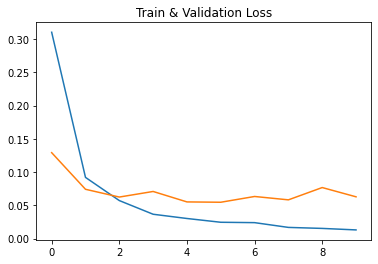

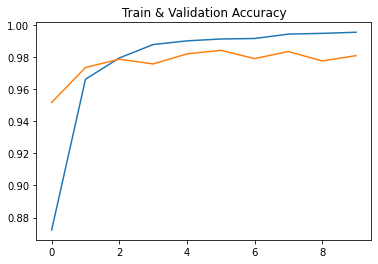

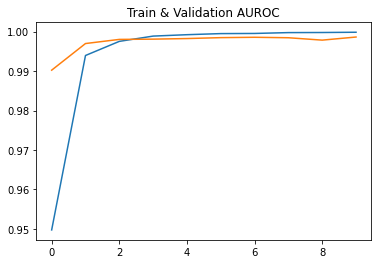

In [13]:
import matplotlib.pyplot as plt

plt.plot(epoch_lst, train_mean_lst)
plt.plot(epoch_lst, val_mean_lst)
plt.title("Train & Validation Loss")
plt.show()

plt.plot(epoch_lst, train_acc_lst)
plt.plot(epoch_lst, val_acc_lst)
plt.title("Train & Validation Accuracy")
plt.show()

plt.plot(epoch_lst, train_auroc_lst)
plt.plot(epoch_lst, val_auroc_lst)
plt.title("Train & Validation AUROC")
plt.show()

## Inference

In [14]:
TRAINED_MODEL_PATH = os.path.join(RESULT_DIR, 'best.pt')

#### Test set Loader

In [15]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']
    
    def data_loader(self):
        print('Loading ' + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()

        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

In [16]:
DATA_DIR=os.path.join(ROOT_PATH, 'pangyo_ai', 'task01_mask', 'test_annot')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading  dataset..


In [17]:
# We made..
if os.path.isfile(os.path.join(DATA_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(DATA_DIR, 'test.pkl'))
else:
    test_db = TestDataset.labeling()
    test_db.to_pickle(os.path.join(DATA_DIR, 'test.pkl'))

In [18]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
target_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, label) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        #file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())
        target_lst.extend(label.cpu().tolist())

acc, roc = get_metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
print('Accuracy: ', acc, ', ', 'AUROC: ', roc)

Accuracy:  0.878167641325536 ,  AUROC:  0.9442132587859424


In [19]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [20]:
DATA_DIR=os.path.join(ROOT_PATH, 'pangyo_ai', 'task01_mask', 'test')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [21]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

#### Save results as csv file

In [22]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, 'mask_pred.csv'), index=False)